## Imports & Functions

In [99]:
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model

import numpy as np
import matplotlib.pyplot as plt
import time
from PIL import Image

%matplotlib inline

In [117]:
def load_and_process_image(image_path):
    #Load and process image to VGG19 format
    img = load_img(image_path)
    img = img_to_array(img)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis = 0)
    return img

def deprocess(x):
    #Functions does reverse preprocessing
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def display_image(image):
    #Show image
    if len(image.shape) == 4:
        img = np.squeeze(image, axis = 0)
        
    img = deprocess(img)
    
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    return

def save_image_iteration(image, file_name, iteration):
    #Save image (correct version via PIL)
    if len(image.shape) == 4:
        img = np.squeeze(image, axis = 0)
        
    img = deprocess(img)
#     file_path = 'StyleTransfer/Style_transfer_' + file_name + '.jpg' #No folder
    file_path = 'StyleTransfer/' + file_name + '/' + str(iteration) + '.jpg'
    im = Image.fromarray(img)
    im.save(file_path)
    print('Image saved to StyleTransfer folder, file name:', file_name)
    

def content_cost(content, generated):
    #MSE for content
    a_C = content_model(content)
    a_G = content_model(generated)
    cost = tf.reduce_mean(tf.square(a_C - a_G))
    return cost

def gram_matrix(A):
    #Calculate Gram Matrix - https://en.wikipedia.org/wiki/Gram_matrix
    n_C = int(A.shape[-1])
    a = tf.reshape(A, [-1, n_C])
    n = tf.shape(a)[0]
    G = tf.matmul(a, a, transpose_a=True)
    return G / tf.cast(n, tf.float32)

def style_cost(style, generated):
    #MSE for style
    J_style = 0
    
    for style_model in style_models:
        a_S = style_model(style)
        a_G = style_model(generated)
        GS = gram_matrix(a_S)
        GG = gram_matrix(a_G)
        current_cost = tf.reduce_mean(tf.square(GS - GG))
        J_style += current_cost * lam
        
    return J_style

def training_loop(content_path, style_path, file_name, iterations = 20, alpha = 10. , beta = 20., save_results = True):
    #Training Loop for style transfer
    if save_results == True:
        os.mkdir('StyleTransfer/' + file_name)
    content = load_and_process_image(content_path)
    style = load_and_process_image(style_path)
    
    generated = tf.Variable(content, dtype = tf.float32)
    
    opt = tf.keras.optimizers.Adam(learning_rate= 7.)
    
    best_cost = 1e12 + 0.1
    best_image = None
    
    start_time = time.time()
    
    for i in range(iterations):
        with tf.GradientTape() as tape:
            J_content = content_cost(content, generated)
            J_style = style_cost(style, generated)
            J_total = alpha * J_content + beta * J_style
            
        grads = tape.gradient(J_total, generated)
        opt.apply_gradients([(grads, generated)])
        
        if J_total < best_cost:
            best_cost = J_total
            best_image = generated.numpy()
            
        print('Cost of {}: {}. Time elapsed:  {}'.format(i, J_total, time.time() - start_time))
        generated_images.append(generated.numpy())
        
        if save_results == True:
            save_image_iteration(generated, file_name, iteration=i)
        
    return best_image
    
    

In [6]:
model = VGG19(
    include_top=False,
    weights='imagenet')

model.trainable = False
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

# Content & Style Models

### Set #1 - Content: Cathedral, Style: Waves, 20 iterations

Cost of 0: 13733986304.0. Time elapsed:  4.0855712890625
Cost of 1: 8505728512.0. Time elapsed:  7.957747220993042
Cost of 2: 5336612352.0. Time elapsed:  11.770381212234497
Cost of 3: 4128448768.0. Time elapsed:  15.792221307754517
Cost of 4: 3317499392.0. Time elapsed:  19.775601148605347
Cost of 5: 2789864192.0. Time elapsed:  23.764801025390625
Cost of 6: 2499667200.0. Time elapsed:  27.685229063034058
Cost of 7: 2264963072.0. Time elapsed:  31.650103092193604
Cost of 8: 2034289024.0. Time elapsed:  35.45255517959595
Cost of 9: 1824829568.0. Time elapsed:  39.79501414299011
Cost of 10: 1641277184.0. Time elapsed:  44.35932540893555
Cost of 11: 1471980544.0. Time elapsed:  48.76716327667236
Cost of 12: 1319641600.0. Time elapsed:  53.07383608818054
Cost of 13: 1195698304.0. Time elapsed:  57.92520236968994
Cost of 14: 1100299520.0. Time elapsed:  62.402348041534424
Cost of 15: 1022350912.0. Time elapsed:  66.46932125091553
Cost of 16: 955063680.0. Time elapsed:  70.314138174057
Cost

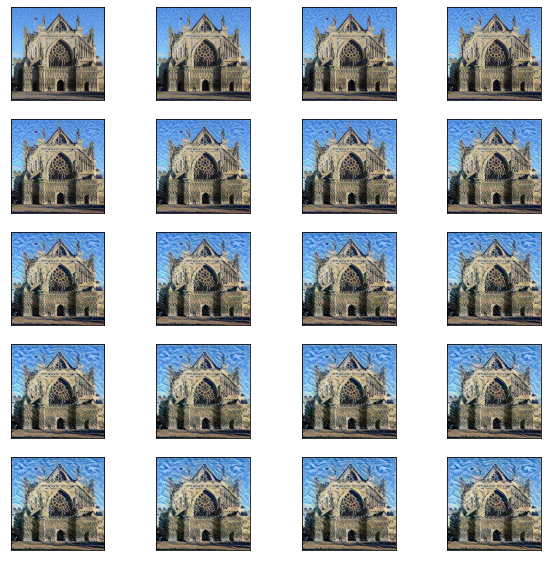

In [37]:
content_layer = 'block5_conv2'

style_layers = ['block1_conv1', 'block3_conv1', 'block5_conv1']


content_model = Model(inputs = model.input, outputs = model.get_layer(content_layer).output)
style_models = [Model(inputs = model.input, outputs = model.get_layer(layer).output) for layer in style_layers]


lam = 1. / len(style_models)
generated_images = []

best_image = training_loop('StyleTransfer/content.jpg', 'StyleTransfer/style.jpg')


#Plot iterations
plt.figure(figsize = (10, 10))

for i in range(20):
    plt.subplot(5, 4, i+1)
    display_image(generated_images[i])
    
plt.show()

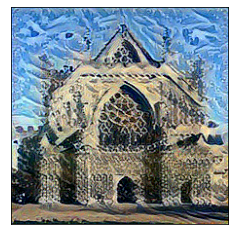

In [38]:
display_image(best_image)

### Set #2 - Content: Batman, Style: Fire, 50 iterations

Cost of 0: 8071055360.0. Time elapsed:  12.439337968826294
Image saved to StyleTransfer folder, file name: Generated_Batman_Fire
Cost of 1: 5550937088.0. Time elapsed:  25.198651790618896
Image saved to StyleTransfer folder, file name: Generated_Batman_Fire
Cost of 2: 4335725568.0. Time elapsed:  38.16279697418213
Image saved to StyleTransfer folder, file name: Generated_Batman_Fire
Cost of 3: 3815137024.0. Time elapsed:  51.07899594306946
Image saved to StyleTransfer folder, file name: Generated_Batman_Fire
Cost of 4: 3506957824.0. Time elapsed:  64.40197992324829
Image saved to StyleTransfer folder, file name: Generated_Batman_Fire


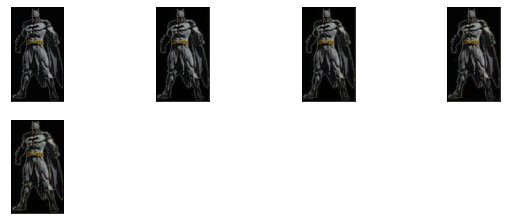

In [118]:
content = 'Batman'
style = 'Fire'
iterations = 5
file_name = 'Generated_' + content + '_' + style


content_layer = 'block5_conv2'
style_layers = ['block1_conv1', 'block3_conv1', 'block5_conv1']
content_model = Model(inputs = model.input, outputs = model.get_layer(content_layer).output)
style_models = [Model(inputs = model.input, outputs = model.get_layer(layer).output) for layer in style_layers]


lam = 1. / len(style_models)
generated_images = []

# def training_loop(content_path, style_path, file_name, iterations = 20, alpha = 10. , beta = 20., save_results = False):
best_image = training_loop('StyleTransfer/content2.png', 'StyleTransfer/style2.jpeg', iterations = iterations, 
                           file_name=file_name)

#Plot iterations
plt.figure(figsize = (10, 10))

for i in range(iterations):
    plt.subplot(5, 4, i+1)
    display_image(generated_images[i])
    
plt.show()
